# 1. PyTorch basics

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Torch (tested on v1.13.0)

### Imports

In [12]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
from numpy.random import default_rng
# OS
import os
# Pickle
import pickle
# Torch
import torch

### Mock dataset, with nonlinearity

As in the previous notebooks, we will reuse our nonlinear binary classification mock dataset and generate a training set with 1000 samples, a test set with 100 samples and a validation set with 100 samples.

In [13]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [14]:
# Generate dataset (train)
np.random.seed(47)
n_points = 1000
train_val1_list, train_val2_list, train_inputs, train_outputs = create_dataset(n_points, min_val, max_val)
# Generate dataset (test)
np.random.seed(17)
n_points_test = 100
test_val1_list, test_val2_list, test_inputs, test_outputs = create_dataset(n_points_test, min_val, max_val)
# Generate dataset (valid)
np.random.seed(27)
n_points_valid = 100
valid_val1_list, valid_val2_list, valid_inputs, valid_outputs = create_dataset(n_points_valid, min_val, max_val)

### Our previous Shallow Neural Net class, with everything

We wil reuse our previous **ShallowNeuralNet** class from Week2 Notebook 7, which:
- implements a Shallow neural network using two fully connected layers and sigmoid activation functions,
- uses a Stochastic Mini-Batch gradient descent, with Adam as its optimizer,
- uses a random normal initialization,
- comes with a forward() method for predictions,
- comes with a backward() and train() method for backpropagation training,
- comes with a cross-entropy loss function and an accuracy calculating loss function,
- comes with a display function, to show training curves on both the loss and the accuracy,
- comes with save and load functions.

In [43]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        
        # Initialize parameters
        self.init_parameters_normal()
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def accuracy(self, inputs, outputs):
        # Calculate accuracy for given inputs and ouputs
        pred = [int(val >= 0.5) for val in self.forward(inputs)]
        acc = sum([int(val1 == val2[0]) for val1, val2 in zip(pred, outputs)])/outputs.shape[0]
        return acc
    
    def backward(self, train_inputs, train_outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, train_inputs, train_outputs, test_inputs, test_outputs, valid_inputs, valid_outputs, \
              N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
              delta = 1e-5, batch_size = 100, display = True):
        # Get number of samples
        M = inputs.shape[0]
        
        # List of losses and accuracies
        self.train_losses_list = [self.CE_loss(train_inputs, train_outputs)]
        self.train_accuracies_list = [self.accuracy(train_inputs, train_outputs)]
        self.valid_losses_list = [self.CE_loss(valid_inputs, valid_outputs)]
        self.valid_accuracies_list = [self.accuracy(valid_inputs, valid_outputs)]
        
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        
        # Define RNG for stochastic minibatches
        rng = default_rng()
        
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Select a subset of inputs and outputs with given batch size
            shuffler = rng.choice(M, size = batch_size, replace = False)
            inputs_sub = train_inputs[shuffler, :]
            outputs_sub = train_outputs[shuffler, :]
            
            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
            
            if(iteration_number % (N_max*0.05) == 1):
                # Update losses list
                train_loss = self.CE_loss(train_inputs, train_outputs)
                self.train_losses_list.append(train_loss)
                valid_loss = self.CE_loss(valid_inputs, valid_outputs)
                self.valid_losses_list.append(valid_loss)

                # Update accuracies
                train_acc = self.accuracy(train_inputs, train_outputs)
                self.train_accuracies_list.append(train_acc)
                valid_acc = self.accuracy(valid_inputs, valid_outputs)
                self.valid_accuracies_list.append(valid_acc)
                
                # Save model
                self.save("./save", iter_num = str(iteration_number), display = display)
                
                # Display
                if (display):
                    message = "Iteration {} ".format(iteration_number)
                    message += "\n - Train Loss = {} - Train Acc = {}".format(train_loss, train_acc)
                    message += "\n - Validation Loss = {} - Validation Acc = {}".format(valid_loss, valid_acc)
                    print(message)
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
                
        # Final display
        message = "Training completed."
        message += "\n - Train Loss = {} - Train Acc = {}".format(train_loss, train_acc)
        message += "\n - Validation Loss = {} - Validation Acc = {}".format(valid_loss, valid_acc)
        message += "\n - Test loss = {}".format(self.CE_loss(test_inputs, test_outputs))
        message += "\n - Test accuracy = {}".format(self.accuracy(test_inputs, test_outputs))
        print(message)
        
        # Save final model
        self.save("./save", display = display)
    
    def show_training_curves(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 3, figsize = (15, 7))
        axs[0].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[0].plot(list(range(len(self.valid_losses_list))), \
                    self.valid_losses_list, "r--", \
                    label = "Valid loss")
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Losses")
        axs[1].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[1].plot(list(range(len(self.valid_losses_list))), \
                    self.valid_losses_list, "r--", \
                    label = "Valid loss")
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Losses (in logarithmic scale)")
        axs[1].set_yscale("log")
        axs[2].plot(list(range(len(self.train_accuracies_list))), \
                    self.train_accuracies_list, "b--", \
                    label = "Train Acc")
        axs[2].plot(list(range(len(self.valid_accuracies_list))), \
                    self.valid_accuracies_list, "r--", \
                    label = "Valid Acc")
        axs[2].set_xlabel("Iteration number")
        axs[2].set_ylabel("Accuracies")
        # Display
        axs[0].legend(loc = "best")
        axs[1].legend(loc = "best")
        axs[2].legend(loc = "best")
        plt.show()
        
    def save(self, path_to_file, iter_num = "final", display = False):
        # Display
        folder = path_to_file + "/" + iter_num + "/"
        if(display):
            print("Saving model to", folder)
        
        # Check if directory exists
        if(not os.path.exists(folder)):
            os.mkdir(folder)
        
        # Dump
        with open(folder + "W1.pkl", 'wb') as f:
            pickle.dump(self.W1, f)
        f.close()
        with open(folder + "W2.pkl", 'wb') as f:
            pickle.dump(self.W2, f)
        f.close()
        with open(folder + "b1.pkl", 'wb') as f:
            pickle.dump(self.b1, f)
        f.close()
        with open(folder + "b2.pkl", 'wb') as f:
            pickle.dump(self.b2, f)
        f.close()
        
    def load(self, path_to_file, iter_num = "final"):
        folder = path_to_file + "/" + iter_num + "/"
        print("Loading model from", folder)
        
        # Load
        with open(folder + "W1.pkl", 'rb') as f:
            self.W1 = pickle.load(f)
        f.close()
        with open(folder + "W2.pkl", 'rb') as f:
            self.W2 = pickle.load(f)
        f.close()
        with open(folder + "b1.pkl", 'rb') as f:
            self.b1 = pickle.load(f)
        f.close()
        with open(folder + "b2.pkl", 'rb') as f:
            self.b2 = pickle.load(f)
        f.close()

We would then train the model by running the commands below.

In [46]:
# Define and train neural network structure
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net = ShallowNeuralNet(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net.train(train_inputs, train_outputs, test_inputs, test_outputs, \
                         valid_inputs, valid_outputs, N_max = 300, alpha = 1e-1, \
                         beta1 = 0.9, beta2 = 0.999, delta = 1e-4, batch_size = 50, display = False)

Training completed.
 - Train Loss = 0.04733916953511414 - Train Acc = 0.993
 - Validation Loss = 0.03691067344418682 - Validation Acc = 1.0
 - Test loss = 0.03916313744380219
 - Test accuracy = 1.0


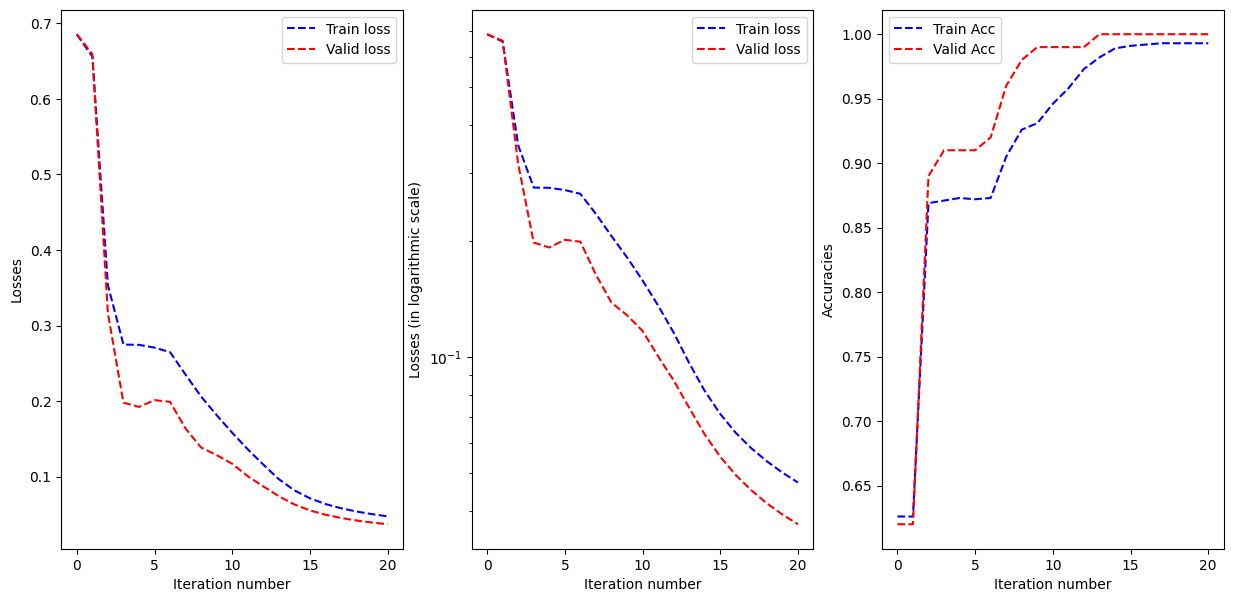

In [47]:
shallow_neural_net.show_training_curves()

### On the benefits of using PyTorch to implement a Neural Network

There are several benefits to using PyTorch over NumPy for implementing neural networks:

- PyTorch provides a more intuitive interface for working with tensors and neural networks. NumPy is primarily a numerical computing library, and while it can be used to perform operations on arrays that are similar to those used in neural networks, PyTorch is specifically designed with deep learning in mind and provides a more natural and convenient interface for defining and training neural networks.
- PyTorch has better support for GPU acceleration than NumPy. If a GPU is available, it can significantly speed up the training of our neural network by performing the computations on the GPU using PyTorch. This can be especially useful for training large and complex models.
- PyTorch includes a number of high-level abstractions for building and training neural networks, such as nn.Module, nn.Sequential, and optim. These abstractions make it easier to write and debug code, and can also improve the performance of our model by allowing PyTorch to apply optimization techniques such as graph fusion and automatic differentiation (which is nice as we will no longer have to worry about the gradient update rules to use!).
- PyTorch has a large and active community of users, coming witha wealth of online resources and documentation to help troubleshoot any issues.

Overall, while NumPy is a powerful library for numerical computing, but PyTorch is a more effective choice for implementing and training neural networks, especially if when taking advantage of GPU acceleration or when using more advanced features such as automatic differentiation.

### Rewriting our class using PyTorch operations instead of Numpy - What will change

...

### Rewriting our class using PyTorch operations instead of Numpy - Init, sigmoid and forward

The main differences between the original class and the PyTorch version in the **ShallowNeuralNet_PT** class are:
- The PyTorch version of the class should inherit from torch.nn.Module and call its parent's init method using super(). This is necessary because PyTorch uses classes inherited from Module to keep track of the layers and their parameters in a neural network.
- Instead of using NumPy arrays for the weights and biases, the PyTorch version uses torch.nn.Parameter objects, which are tensors that are optimized by PyTorch's optimizers.
- The activation function sigmoid is replaced with PyTorch's torch.sigmoid function.
- In the CE_loss and accuracy methods, we will reuse the torch functions and methods as much as possible, instead of the Numpy ones.

In [59]:
# Our class will inherit from the torch.nn.Module
# used to write all model in PyTorch
class ShallowNeuralNet_PT(torch.nn.Module):
    
    def __init__(self, n_x, n_h, n_y):
        # Super __init__ for inheritance
        super().__init__()
        
        # Network dimensions (as before)
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        
        # Initialize parameters using the torch.nn.Parameter type!
        # We immediatly initialize the parameters using a random normal.
        # The RNG is done using torch.randn instead of the NumPy RNG.
        # We add a conversion into float64 (the same float type used by Numpy to generate our data)
        self.W1 = torch.nn.Parameter(torch.randn(n_x, n_h, requires_grad = True)*0.1).type(torch.float64)
        self.b1 = torch.nn.Parameter(torch.randn(1, n_h, requires_grad = True)*0.1).type(torch.float64)
        self.W2 = torch.nn.Parameter(torch.randn(n_h, n_y, requires_grad = True)*0.1).type(torch.float64)
        self.b2 = torch.nn.Parameter(torch.randn(1, n_y, requires_grad = True)*0.1).type(torch.float64)
        
    def forward(self, inputs):
        # Instead of using np.matmul(), we use its equivalent in PyTorch,
        # which is torch.matmul()!
        # (Most numpy matrix operations ahve their equivalent in torch, check it out!)
        # Wx + b operation for the first layer
        Z1 = torch.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Sigmoid is already implemented in PyTorch, feel fre to reuse it!
        A1 = torch.sigmoid(Z1_b)
        
        # Wx + b operation for the second layer
        # (Same as first layer)
        Z2 = torch.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = torch.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        pred = self.forward(inputs)
        
        # We will use an epsilon to avoid NaNs on the log() values
        eps = 1e-10
        
        # As before with matmul, most operations in NumPy have their equivalent in torch (e.g. log and sum)
        losses = outputs * torch.log(pred + eps) + (1 - outputs) * torch.log(1 - pred + eps)
        loss = -torch.sum(losses)/outputs.shape[0]
        
        return loss
    
    def accuracy(self, inputs, outputs):
        # Calculate accuracy for given inputs and ouputs
        # We will, again, rely as much as possible on the torch methods and functions. 
        pred = (self.forward(inputs) >= 0.5).int()
        return (pred == outputs).float().mean()

Before we are able to use this Neural Network on our dataset, we need to convert them to PyTorch Tensor objects.

In [60]:
train_inputs_pt = torch.from_numpy(train_inputs)
train_outputs_pt = torch.from_numpy(train_outputs)
test_inputs_pt = torch.from_numpy(test_inputs)
test_outputs_pt = torch.from_numpy(test_inputs)
valid_inputs_pt = torch.from_numpy(valid_inputs)
valid_outputs_pt = torch.from_numpy(valid_inputs)

In [62]:
# Define and train neural network structure
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_pt = ShallowNeuralNet_PT(n_x, n_h, n_y)
# Predict on train_samples
pred = shallow_neural_net_pt.forward(train_inputs_pt)
print(pred)

tensor([[0.4983],
        [0.4995],
        [0.4987],
        [0.4989],
        [0.4988],
        [0.4996],
        [0.4992],
        [0.4990],
        [0.4992],
        [0.4987],
        [0.4988],
        [0.4987],
        [0.4987],
        [0.4989],
        [0.4992],
        [0.4991],
        [0.4988],
        [0.4993],
        [0.4986],
        [0.4990],
        [0.4994],
        [0.4985],
        [0.4989],
        [0.4981],
        [0.4995],
        [0.4993],
        [0.4987],
        [0.4995],
        [0.4986],
        [0.4985],
        [0.4990],
        [0.4987],
        [0.4986],
        [0.4993],
        [0.4986],
        [0.4989],
        [0.4993],
        [0.4984],
        [0.4984],
        [0.4988],
        [0.4989],
        [0.4986],
        [0.4986],
        [0.4988],
        [0.4984],
        [0.4984],
        [0.4992],
        [0.4996],
        [0.4990],
        [0.4989],
        [0.4987],
        [0.4985],
        [0.4983],
        [0.4992],
        [0.4983],
        [0

### What's next?

This is the last notebook for this week.

Next week, we will investigate the PyTorch framework, and start implementing (Deep) Neural Networks more efficiently.